# 002—Normlization

## 1. BatchNorm

In [12]:
import torch
import torch.nn as nn

### 1.1 官网API

In [24]:
# torch官网案例（BatchNorm1d）
    # Examples::

    #     >>> # With Learnable Parameters
    #     >>> m = nn.BatchNorm1d(100)
    #     >>> # Without Learnable Parameters
    #     >>> m = nn.BatchNorm1d(100, affine=False)
    #     >>> input = torch.randn(20, 100)
    #     >>> output = m(input)

m = nn.BatchNorm1d(100)  # num_features
ipt = torch.randn(20, 100)
print(ipt[:][1].mean())
print(ipt[:][1].var())  # 1.0085*1.0085
print(ipt[:][1].std())
input[:][1].shape

tensor(0.0283)
tensor(1.0125)
tensor(1.0063)


torch.Size([100])

In [25]:
output = m(ipt)
print(output[:][1].mean())
print(output[:][1].var())  # 1.0085*1.0085
print(output[:][1].std())
output.shape

tensor(0.0039, grad_fn=<MeanBackward0>)
tensor(1.0687, grad_fn=<VarBackward0>)
tensor(1.0338, grad_fn=<StdBackward0>)


torch.Size([20, 100])

In [52]:
ipt = torch.randint(-20, 30, size=(20, 100), dtype=torch.float)
torch.mean(ipt[:][1])
# torch.mean(ipt, dtype=torch.float)

tensor(4.1900)

In [53]:
ipt.max(), ipt.min()

(tensor(29.), tensor(-20.))

In [54]:
out = m(ipt)

In [65]:
out.mean(), out.var(), out.shape

(tensor(4.5300e-09, grad_fn=<MeanBackward0>),
 tensor(1.0005, grad_fn=<VarBackward0>),
 torch.Size([20, 100]))

In [73]:
print(out[:, 1].shape)
print(out[:, 1].mean())
print(out[:, 1].var())
print(out[:, 1].std())
print()
print(out[1, :].shape)
print(out[1, :].mean())
print(out[1, :].var())
print(out[1, :].std())
print()
print(out.shape)
print(out.mean())
print(out.var())
print(out.std())


torch.Size([20])
tensor(-1.1921e-08, grad_fn=<MeanBackward0>)
tensor(1.0526, grad_fn=<VarBackward0>)
tensor(1.0260, grad_fn=<StdBackward0>)

torch.Size([100])
tensor(-0.0420, grad_fn=<MeanBackward0>)
tensor(1.1419, grad_fn=<VarBackward0>)
tensor(1.0686, grad_fn=<StdBackward0>)

torch.Size([20, 100])
tensor(4.5300e-09, grad_fn=<MeanBackward0>)
tensor(1.0005, grad_fn=<VarBackward0>)
tensor(1.0003, grad_fn=<StdBackward0>)


### 1.2 自己实现

In [125]:
class BatchNorm(nn.Module):
    def __init__(self, num_features, eps=1e-5, momentum=0.1):
        super(BatchNorm, self).__init__()
        self.num_features = num_features
        self.eps = eps

        self.gamma = nn.Parameter(torch.ones(num_features))  # 这俩是可学习参数
        self.beta = nn.Parameter(torch.zeros(num_features))
        self.momentum = momentum

        # 这里简化写法，不使用buffer注册
        self.running_mean = torch.ones(num_features)
        self.running_var = torch.zeros(num_features)  

    def forward(self, x, training=True):
        if training:
            batch_mean = x.mean(dim=0)
            batch_var = x.var(dim=0, unbiased=False) # 计算时候无偏，存储时候有偏
            print("batch_mean shape, batch_var shape:", batch_mean.shape, batch_var.shape)
            self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * batch_mean
            self.running_var = (1 - self.momentum) * self.running_var + self.momentum * batch_var
            print("self.running_mean, self.running_var:", self.running_mean, self.running_var)

        else:
            batch_mean, batch_var = self.running_mean, self.running_var

        return self.gamma * (x - batch_mean) / (torch.sqrt(batch_var + self.eps)) + self.beta

        

In [128]:
if __name__ == '__main__':
    batch_norm = BatchNorm(10)
    ipt = torch.randn(size=(2, 10))
    print(ipt[1].shape)
    res = batch_norm(ipt)
    print(res)
    print(res.min(), res.max())

torch.Size([10])
batch_mean shape, batch_var shape: torch.Size([10]) torch.Size([10])
self.running_mean, self.running_var: tensor([0.8057, 0.8289, 0.9631, 0.9466, 0.8408, 0.8254, 0.9118, 0.7609, 0.8584,
        0.9538]) tensor([1.7758e-02, 2.3158e-02, 4.2861e-03, 2.0917e-01, 2.3926e-02, 2.9425e-04,
        5.5038e-01, 9.3083e-02, 1.7920e-04, 2.1863e-04])
tensor([[ 1.0000, -1.0000, -1.0000, -1.0000,  1.0000,  0.9998, -1.0000, -1.0000,
         -0.9998, -0.9998],
        [-1.0000,  1.0000,  1.0000,  1.0000, -1.0000, -0.9998,  1.0000,  1.0000,
          0.9998,  0.9998]], grad_fn=<AddBackward0>)
tensor(-1.0000, grad_fn=<MinBackward1>) tensor(1.0000, grad_fn=<MaxBackward1>)


In [129]:
res = batch_norm(ipt)
print(res)
res.min(), res.max()

batch_mean shape, batch_var shape: torch.Size([10]) torch.Size([10])
self.running_mean, self.running_var: tensor([0.6308, 0.6748, 0.9299, 0.8986, 0.6976, 0.6684, 0.8324, 0.5457, 0.7310,
        0.9121]) tensor([3.3740e-02, 4.4000e-02, 8.1436e-03, 3.9743e-01, 4.5460e-02, 5.5908e-04,
        1.0457e+00, 1.7686e-01, 3.4049e-04, 4.1541e-04])
tensor([[ 1.0000, -1.0000, -1.0000, -1.0000,  1.0000,  0.9998, -1.0000, -1.0000,
         -0.9998, -0.9998],
        [-1.0000,  1.0000,  1.0000,  1.0000, -1.0000, -0.9998,  1.0000,  1.0000,
          0.9998,  0.9998]], grad_fn=<AddBackward0>)


(tensor(-1.0000, grad_fn=<MinBackward1>),
 tensor(1.0000, grad_fn=<MaxBackward1>))

## 2. LayerNorm

### 2.1 官网API

In [ ]:
# Examples::

#     >>> # NLP Example
#     >>> batch, sentence_length, embedding_dim = 20, 5, 10
#     >>> embedding = torch.randn(batch, sentence_length, embedding_dim)
#     >>> layer_norm = nn.LayerNorm(embedding_dim)
#     >>> # Activate module
#     >>> layer_norm(embedding)
#     >>>
#     >>> # Image Example
#     >>> N, C, H, W = 20, 5, 10, 10
#     >>> input = torch.randn(N, C, H, W)
#     >>> # Normalize over the last three dimensions (i.e. the channel and spatial dimensions)
#     >>> # as shown in the image below
#     >>> layer_norm = nn.LayerNorm([C, H, W])
#     >>> output = layer_norm(input)


In [137]:
from torch.nn import LayerNorm
batch_size, seq_length, embedding_dim = 2, 5, 10
embedding = torch.randn(batch_size, seq_length, embedding_dim)
layer_norm = nn.LayerNorm(embedding_dim)
layer_norm

LayerNorm((10,), eps=1e-05, elementwise_affine=True)

In [138]:
layer_norm(embedding).shape

torch.Size([2, 5, 10])

### 2.2 自己实现

In [152]:
# 这里我只实现NLP的样式
class LayerNormImpl(nn.Module):
    def __init__(self, normalized_shape: tuple, eps=1e-5):
        super().__init__()
        self.eps = eps

        self.gamma = nn.Parameter(torch.ones(normalized_shape))
        self.beta = nn.Parameter(torch.zeros(normalized_shape))

    def forward(self, x):  # [batch_szie, seq_len, embedding_dim]
        emb_mean = x.mean(dim=-1, keepdim=True)
        emb_var = x.var(dim=-1, keepdim=True, unbiased=False)

        norm_x = (x - emb_mean) / (torch.sqrt(emb_var + self.eps))

        return self.gamma * norm_x + self.beta
        
        

In [153]:
batch_size, seq_length, embedding_dim = 2, 5, 10
embedding_size = [batch_size, seq_length, embedding_dim]
ipt = torch.randn(batch_size, seq_length, embedding_dim)
layer_norm = LayerNormImpl(embedding_size)


In [154]:
layer_norm(ipt).shape

torch.Size([2, 5, 10])

In [155]:
layer_norm(ipt).max(), layer_norm(ipt).min()

(tensor(2.1258, grad_fn=<MaxBackward1>),
 tensor(-2.0262, grad_fn=<MinBackward1>))

In [167]:
out = layer_norm(ipt)

In [183]:
out[1, :].max(dim=-1)

torch.return_types.max(
values=tensor([2.1258, 1.6825, 1.4037, 1.3946, 1.7632], grad_fn=<MaxBackward0>),
indices=tensor([2, 6, 7, 2, 1]))

In [184]:
out[1, :].min(dim=-1)

torch.return_types.min(
values=tensor([-1.6328, -1.3399, -1.6296, -1.8342, -1.1033], grad_fn=<MinBackward0>),
indices=tensor([3, 0, 3, 7, 9]))

## 3. GroupNorm

In [185]:
# 对Batch Nrom的改动，对channl维度进行分组
pass

## 4. RMSNorm

### 4.1 官网API

In [ ]:
# Examples::

#     >>> rms_norm = nn.RMSNorm([2, 3])
#     >>> input = torch.randn(2, 2, 3)
#     >>> rms_norm(input)

In [187]:
rms_norm = nn.RMSNorm([2, 3])
ipt = torch.randn(2, 2, 3)
rms_norm(ipt)

tensor([[[ 0.1696, -0.8762, -1.3864],
         [ 0.0203, -1.7726,  0.3728]],

        [[ 1.2740,  0.2570,  0.3388],
         [ 1.0890,  0.5280,  1.6527]]], grad_fn=<MulBackward0>)

### 4.2 自己实现

In [237]:
# 对Layer Norm的优化，采用均方根，并假设重新计算的中心化无关（去掉平移）
class RMSNorm(nn.Module):
    def __init__(self, normlized_shape: tuple, eps=1e-5):
        super().__init__()
        self.normlized_shape = normlized_shape
        self.eps = eps

        self.gamma = nn.Parameter(torch.ones(normlized_shape))

    def forward(self, x):
        # print(tuple(x.shape) == self.normlized_shape)
        assert tuple(x.shape) == self.normlized_shape, "归一化形状与输入形状不一致"

        rms = torch.sqrt(x.pow(2).mean(dim=-1, keepdim=True) + self.eps)
        
        return self.gamma *  x / rms 
       

In [238]:
batch_size, seq_length, embedding_dim = 2, 5, 10
embedding_size = (batch_size, seq_length, embedding_dim)
ipt = torch.randn(embedding_size)
rms_norm = RMSNorm(embedding_size)

In [239]:
out = rms_norm(ipt)
print(out.shape)
print(out.max(), out.min())

torch.Size([2, 5, 10])
tensor(2.2343, grad_fn=<MaxBackward1>) tensor(-2.0097, grad_fn=<MinBackward1>)


In [240]:
out.max(dim=-1), print(), out.min(dim=-1)

(torch.return_types.max(
 values=tensor([[2.1517, 1.5508, 1.2936, 0.9373, 1.0745],
         [1.7776, 1.9607, 2.0123, 1.8904, 2.2343]], grad_fn=<MaxBackward0>),
 indices=tensor([[3, 5, 3, 4, 9],
         [3, 4, 4, 9, 1]])),
 None,
 torch.return_types.min(
 values=tensor([[-1.2241, -1.6148, -1.8941, -2.0097, -1.9332],
         [-1.3606, -1.1657, -0.9142, -1.4892, -1.0552]], grad_fn=<MinBackward0>),
 indices=tensor([[8, 6, 1, 8, 5],
         [1, 6, 1, 4, 8]])))

In [241]:
out.mean(dim=-1), out.var(dim=-1)

(tensor([[ 0.1349, -0.0799,  0.0191, -0.1794, -0.6099],
         [ 0.1504,  0.0668,  0.4763,  0.2718,  0.2192]],
        grad_fn=<MeanBackward1>),
 tensor([[1.0909, 1.1040, 1.1107, 1.0753, 0.6978],
         [1.0859, 1.1061, 0.8590, 1.0290, 1.0577]], grad_fn=<VarBackward0>))

## 5. DyT

In [242]:
# 官网暂时还没有该部分代码（2025-05）

In [254]:
from torch.nn.functional import tanh

class DyT(nn.Module):
    def __init__(self, normlizated_shape: tuple, init_alpha=0.5):
        super().__init__()
        self.normlizated_shape = normlizated_shape
        self.alpha = nn.Parameter(torch.ones(1) * init_alpha)
        self.gamma = nn.Parameter(torch.ones(normlizated_shape))
        self.beta = nn.Parameter(torch.zeros(normlizated_shape))

    def forward(self, x):
        assert tuple(x.shape) == self.normlizated_shape, "输入形状与归一化形状不匹配"
        x = tanh(self.alpha * x)
        return self.gamma * x + self.beta 

In [255]:
batch_size, seq_length, embedding_dim = 2, 5, 10
embedding_size = (batch_size, seq_length, embedding_dim)
ipt = torch.randn(embedding_size)
dyt = DyT(embedding_size)

In [275]:
res = dyt(ipt)
res.shape

torch.Size([2, 5, 10])

In [276]:
res.max(dim=-1), res.min(dim=-1)

(torch.return_types.max(
 values=tensor([[0.8203, 0.7529, 0.8622, 0.4247, 0.4482],
         [0.8624, 0.5836, 0.5179, 0.5633, 0.5837]], grad_fn=<MaxBackward0>),
 indices=tensor([[4, 8, 5, 0, 2],
         [0, 3, 7, 8, 8]])),
 torch.return_types.min(
 values=tensor([[-0.7481, -0.6718, -0.7155, -0.3006, -0.4286],
         [-0.5702, -0.3776, -0.7690, -0.6800, -0.7936]], grad_fn=<MinBackward0>),
 indices=tensor([[0, 3, 3, 6, 6],
         [9, 9, 5, 6, 1]])))

In [277]:
res.mean(dim=-1), res.var(dim=-1)

(tensor([[ 0.1602,  0.2414,  0.0184,  0.0084, -0.0264],
         [ 0.0599,  0.1107, -0.0758, -0.0020, -0.0995]],
        grad_fn=<MeanBackward1>),
 tensor([[0.2148, 0.1875, 0.2123, 0.0839, 0.1110],
         [0.2266, 0.0925, 0.1626, 0.1417, 0.2744]], grad_fn=<VarBackward0>))

In [278]:
import matplotlib.pyplot as plt
import numpy as np

In [279]:
res = res.reshape(-1, )
res.shape

torch.Size([100])

In [281]:
res_np = res.detach().numpy()
res_np.sort()
res_np

array([-0.79356986, -0.7689823 , -0.74814284, -0.7475678 , -0.71650153,
       -0.7154637 , -0.6799526 , -0.67183614, -0.65581584, -0.5702313 ,
       -0.48244542, -0.47687936, -0.4451822 , -0.42861864, -0.3839705 ,
       -0.3787838 , -0.37755352, -0.37554508, -0.34520176, -0.3006487 ,
       -0.29858166, -0.27985305, -0.25514433, -0.24762094, -0.24531674,
       -0.23665027, -0.23307872, -0.23291336, -0.23241825, -0.20922378,
       -0.199445  , -0.18063533, -0.17918357, -0.14061967, -0.11379912,
       -0.08196156, -0.08108743, -0.07945291, -0.07529972, -0.03915898,
       -0.03047188, -0.02075537,  0.00135301,  0.0137195 ,  0.01712114,
        0.04349285,  0.05948048,  0.06080786,  0.06664807,  0.07018054,
        0.09192327,  0.10553732,  0.10567111,  0.1080163 ,  0.1083034 ,
        0.10952533,  0.11364294,  0.12288477,  0.14704394,  0.15046829,
        0.15655723,  0.17734955,  0.19497323,  0.20756477,  0.21143068,
        0.21245368,  0.2140043 ,  0.22466962,  0.23171824,  0.24

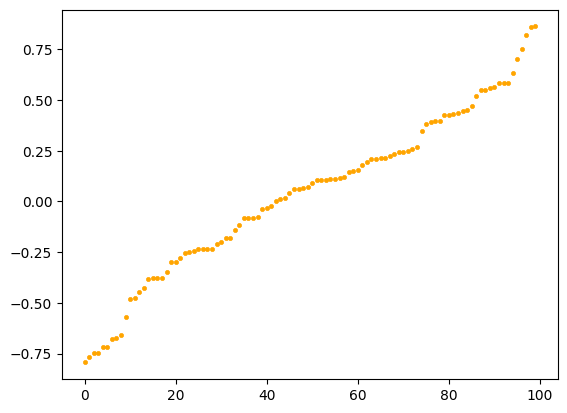

In [302]:
x = np.arange(100)
plt.scatter(x, res_np, color='orange', marker='.', linewidths=0.5)
plt.show()

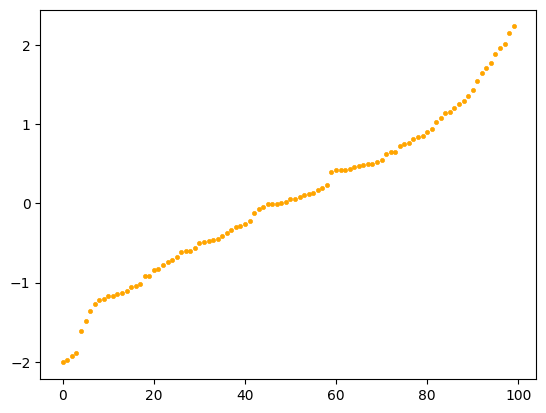

In [308]:
out = out.reshape(-1, )
out_np = out.detach().numpy()
out_np.sort()
x = np.arange(100)
plt.scatter(x, out_np, color='orange', marker='.', linewidths=0.5)
plt.show()

## 6. Post-Norm & Pre-Norm